In [10]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers, ops, Model, random

import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import label_binarize
from tensorflow.keras import regularizers
import seaborn as sns
from tensorflow.keras.layers import Conv2D, Lambda, MaxPooling2D, BatchNormalization, ReLU, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Dropout, Flatten, Input, Reshape, Conv2DTranspose, LeakyReLU, UpSampling2D, GaussianNoise, SpatialDropout2D, Concatenate
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
tfd = tfp.distributions

In [11]:
# Download Galaxy10 DECaLS (HDF5)
! rm ./Galaxy10_DECals_64.h5
! wget https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
data_path = "./Galaxy10_DECals_64.h5"

print("Downloaded to:", data_path)

--2025-12-03 19:24:50--  https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.170.17, 128.142.53.28, 128.142.53.35, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.170.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159140118 (152M) [application/octet-stream]
Saving to: ‘Galaxy10_DECals_64.h5’

Galaxy10_DECals_64. 100%[===================>] 151.77M  16.1MB/s    in 11s     

2025-12-03 19:25:02 (13.7 MB/s) - ‘Galaxy10_DECals_64.h5’ saved [159140118/159140118]

Downloaded to: ./Galaxy10_DECals_64.h5


In [12]:
# Load images and labels using h5py
with h5py.File(data_path, "r") as f:
    images = np.array(f["images"])   # shape (17736, 256, 256, 3)
    labels = np.array(f["ans"])      # shape (17736,)

#  normalize pixels in [0,1]
images = images/255

print("Images shape:", images.shape)
print("Labels shape:", labels.shape, "dtype:", labels.dtype)

Images shape: (17736, 64, 64, 3)
Labels shape: (17736,) dtype: uint8


In [13]:
# Create anomaly dataset: all class 4 images
ANOMALY_CLASS = 0

anomaly_mask = (labels == ANOMALY_CLASS)
standard_mask = ~anomaly_mask

anom_images = images[anomaly_mask]
anom_labels = labels[anomaly_mask]  # all 0, but we keep them for bookkeeping

std_images = images[standard_mask]
std_labels_original = labels[standard_mask]

print("Standard images:", std_images.shape)
print("Anomaly images:", anom_images.shape)

Standard images: (16655, 64, 64, 3)
Anomaly images: (1081, 64, 64, 3)


In [14]:
# For training, remap standard labels from {0,...,9} -> {0,...,8}
unique_std_classes = sorted(np.unique(std_labels_original))
print("Standard classes (original indices):", unique_std_classes)

# Create mapping dict
label_map = {original: new for new, original in enumerate(unique_std_classes)}
inv_label_map = {v: k for k, v in label_map.items()}

print("Label map (original -> new):", label_map)

std_labels = np.vectorize(label_map.get)(std_labels_original)
print("Remapped standard labels min/max:", std_labels.min(), std_labels.max())
n_classes = len(unique_std_classes)

Standard classes (original indices): [np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]
Label map (original -> new): {np.uint8(1): 0, np.uint8(2): 1, np.uint8(3): 2, np.uint8(4): 3, np.uint8(5): 4, np.uint8(6): 5, np.uint8(7): 6, np.uint8(8): 7, np.uint8(9): 8}
Remapped standard labels min/max: 0 8


In [15]:
# Split standard data: 50% train, 25% val, 25% test

# First split: train (50%) and temp (50%)
X_train_std, X_temp_std, y_train_std, y_temp_std = train_test_split(
    std_images,
    std_labels,
    test_size=0.5,
    stratify=std_labels,
    random_state=42
)

# Second split: temp into val (25%) and test (25%) of full standard data
X_val_std, X_test_std, y_val_std, y_test_std = train_test_split(
    X_temp_std,
    y_temp_std,
    test_size=0.5,
    stratify=y_temp_std,
    random_state=42
)

print("Train standard:", X_train_std.shape, y_train_std.shape)
print("Val standard:  ", X_val_std.shape, y_val_std.shape)
print("Test standard: ", X_test_std.shape, y_test_std.shape)
del std_images, std_labels, X_temp_std, y_temp_std

Train standard: (8327, 64, 64, 3) (8327,)
Val standard:   (4164, 64, 64, 3) (4164,)
Test standard:  (4164, 64, 64, 3) (4164,)


In [16]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [17]:
# --------------------------------------------------------
# Encoder
# --------------------------------------------------------
LATENT_DIM = 16
INPUT_SHAPE = (64, 64, 3)

encoder_inputs = keras.Input(shape=INPUT_SHAPE)

x = layers.Conv2D(32, 3, strides=2, padding="same")(encoder_inputs)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)

z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# --------------------------------------------------------
# Decoder
# --------------------------------------------------------
latent_inputs = keras.Input(shape=(LATENT_DIM,))

# Start from 4×4 feature map → 64×64 output after 4 upsampling steps
x = layers.Dense(4 * 4 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 256))(x)

x = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# Output: 64×64×3, sigmoid for image model
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 128) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  1,048,704 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      2,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      2,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,146,080 (4.37 MB)

 Trainable params: 1,146,080 (4.37 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,049,795 (4.00 MB)

 Trainable params: 1,048,835 (4.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [18]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, flow, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.flow = flow                      # <-- RealNVP instance
        self.beta = tf.Variable(0.1, trainable=False)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:

            # Encode -> z0 (Gaussian)
            z_mean, z_log_var, z0 = self.encoder(data)

            # Pass through flow → zK
            zK, log_det = self.flow(z0, training=False)
            # RealNVP returns log(det ∂z0/∂zK^{-1}), so KL gets a minus-sign:

            # Decode final latent
            reconstruction = self.decoder(zK)

            # === Reconstruction Loss ===
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=[1,2,3]))

            # === Base VAE KL ===
            base_kl = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))

            # === Flow correction ===
            kl_loss = base_kl - tf.reduce_mean(log_det)   # <-- Correct term!

            total_loss = recon_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {"loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}


In [19]:
output_dim = 512
reg = 1e-4

def Coupling(input_dim):
    """Return a Keras Model that outputs (s, t) given x_masked."""
    inp = keras.Input(shape=(input_dim,))

    # Translation network t(x_masked)
    t = layers.Dense(output_dim, activation="relu",
                     kernel_regularizer=regularizers.l2(reg))(inp)
    t = layers.Dense(output_dim, activation="relu",
                     kernel_regularizer=regularizers.l2(reg))(t)
    t = layers.Dense(output_dim, activation="relu",
                     kernel_regularizer=regularizers.l2(reg))(t)
    t = layers.Dense(input_dim, activation="linear",
                     kernel_regularizer=regularizers.l2(reg))(t)

    # Scale network s(x_masked)
    s = layers.Dense(output_dim, activation="relu",
                     kernel_regularizer=regularizers.l2(reg))(inp)
    s = layers.Dense(output_dim, activation="relu",
                     kernel_regularizer=regularizers.l2(reg))(s)
    s = layers.Dense(output_dim, activation="relu",
                     kernel_regularizer=regularizers.l2(reg))(s)
    s = layers.Dense(input_dim, activation="tanh",
                     kernel_regularizer=regularizers.l2(reg))(s)

    return keras.Model(inp, [s, t])

In [20]:
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers, data_dim):
        super().__init__()
        self.num_coupling_layers = num_coupling_layers
        self.data_dim = data_dim

        # Base distribution in latent space z
        self.distribution = tfd.MultivariateNormalDiag(
            loc=tf.zeros(data_dim),
            scale_diag=tf.ones(data_dim)
        )

        # Create alternating binary masks (0/1) over 784 dims
        mask0 = np.array([i % 2 for i in range(data_dim)], dtype="float32")
        mask1 = 1.0 - mask0
        masks = []
        for i in range(num_coupling_layers):
            masks.append(mask0 if i % 2 == 0 else mask1)
        self.masks = tf.constant(np.stack(masks, axis=0))  # (L, D)

        # Track loss as a metric
        self.loss_tracker = keras.metrics.Mean(name="loss")

        # One coupling network per layer
        self.layers_list = [Coupling(data_dim) for _ in range(num_coupling_layers)]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        """
        Forward pass.

        training=True  -> data -> latent (inverse flow in RealNVP paper)
        training=False -> latent -> data (sampling)
        """
        log_det_inv = 0.0
        direction = -1 if training else 1

        if direction == -1:
            layer_iter = range(self.num_coupling_layers - 1, -1, -1)
        else:
            layer_iter = range(self.num_coupling_layers)

        for i in layer_iter:
            mask = self.masks[i]                 # (D,)
            x_masked = x * mask
            reversed_mask = 1.0 - mask

            s, t = self.layers_list[i](x_masked)  # each (B, D)
            s = s * reversed_mask
            t = t * reversed_mask

            gate = (direction - 1.0) / 2.0
            # RealNVP affine coupling transform
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )

            log_det_inv += gate * tf.reduce_sum(s, axis=1)

        return x, log_det_inv

    def log_loss(self, x):
        # map x -> z  (training=True)
        y, logdet = self(x, training=True)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            loss = self.log_loss(x)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def sample(self, num_samples):
        """Draw samples in data space."""
        z = self.distribution.sample(num_samples)      # latent samples
        x, _ = self(z, training=False)                 # invert the flow
        return tf.clip_by_value(x, 0.0, 1.0)

In [21]:
flow = RealNVP(num_coupling_layers=8, data_dim=LATENT_DIM)

vae = VAE(encoder, decoder, flow)
vae.compile(optimizer=keras.optimizers.Adam(1e-4))
history = vae.fit(X_train_std, epochs=50)

Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 49s 62ms/step - kl_loss: 2.7096 - loss: 531.7427 - reconstruction_loss: 531.4716
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - kl_loss: 11.5967 - loss: 85.0961 - reconstruction_loss: 83.9364
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - kl_loss: 16.8637 - loss: 58.5235 - reconstruction_loss: 56.8372
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - kl_loss: 16.0035 - loss: 53.4938 - reconstruction_loss: 51.8934
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - kl_loss: 17.1352 - loss: 49.8561 - reconstruction_loss: 48.1426
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - kl_loss: 18.9972 - loss: 45.2105 - reconstruction_loss: 43.3107
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - kl_loss: 19.7088 - loss: 43.5816 - reconstruction_loss: 41.6108
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - kl_loss: 19.4074 - loss: 42.3899 - reconstruction_loss: 40.4492
Epoch 9/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 18m

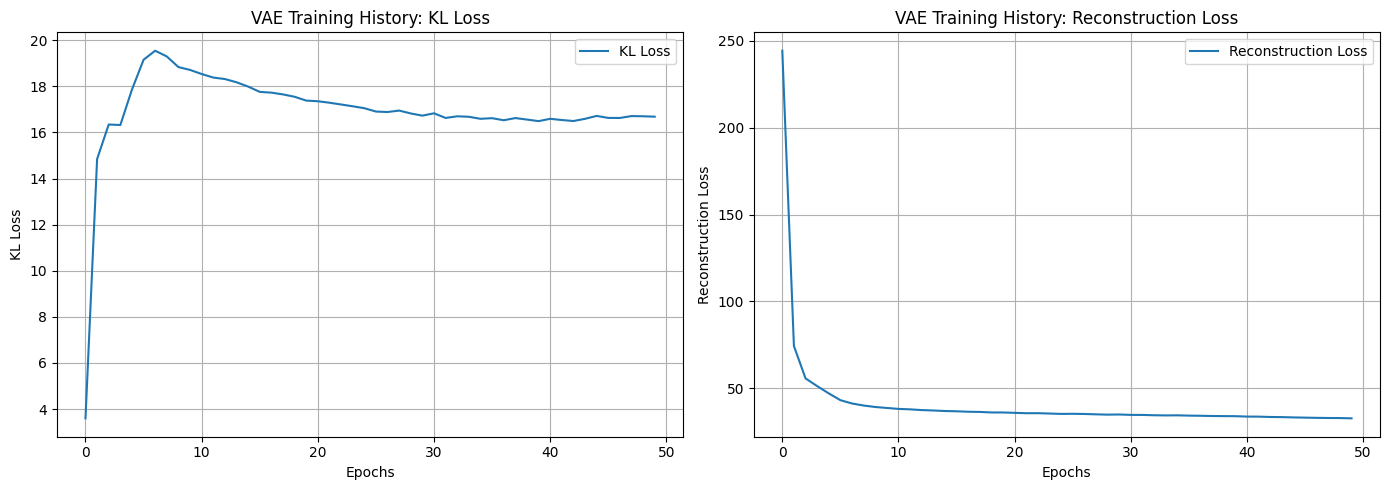

In [22]:
# Plot losses
plt.figure(figsize=(14, 5))

# Plot the KL Loss history
plt.subplot(1, 2, 1) # 1 row, 2 columns, first subplot
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.title('VAE Training History: KL Loss')
plt.xlabel('Epochs')
plt.ylabel('KL Loss')
plt.legend()
plt.grid(True)

# Plot the Reconstruction Loss history
plt.subplot(1, 2, 2) # 1 row, 2 columns, second subplot
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.title('VAE Training History: Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

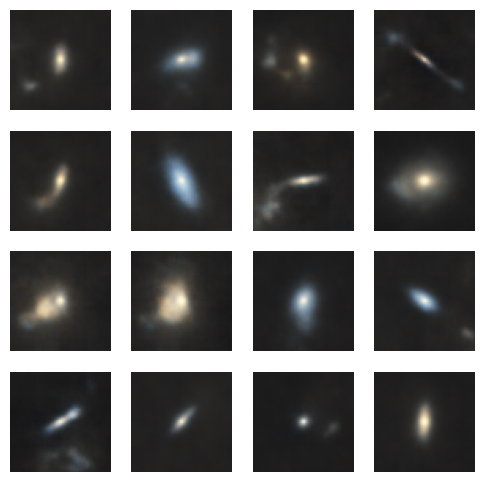

In [23]:
def sample_images(vae, num_samples=16):
    # Step 1: sample from base Gaussian in latent space
    z0 = tf.random.normal((num_samples, LATENT_DIM))

    # Step 2: pass through flow *in reverse direction*  (latent → flow^{-1} → zK)
    zK, logdet = flow(z0, training=False)
    # The NF is trained to warp the Gaussian into a richer latent space that matches the true data distribution better.
    # So if we bypass the flow and sample decoder(z0) directly, the samples won’t follow the model’s learned latent distribution.

    # Step 3: decode into image space
    images = vae.decoder(zK)

    return images

imgs = sample_images(vae, 16)

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(imgs[i].numpy())
    plt.axis('off')
plt.show()
